#### 1. Định nghĩa bài toán
- Lunar Lander là một bài toán học tăng cường, cụ thể là 1 bài toán Quyết định Markov (MDP) rời rạc.
$$M=\{S,A,P,R,\gamma\}$$
- Trong đó:
##### Không gian trạng thái ($S$)
- Theo định nghĩa từ Gymnasium, không gian trạng thái rời rạc $S \subset R^8$ 
- Mỗi trạng thái $s\in S$ là vector gồm 8 giá trị:
$$s=[x,y,v_{x},v_{y},\theta,\omega,c_{l},c_{r}]$$
- Với:
	- $x,y:$ toạ độ của con tàu theo trục $x,y$
	- $v_{x},v_{y}:$ vận tốc của con tàu theo các phương $x,y$
	- $\theta:$ góc quay của con tàu
	- $\omega:$ vận tốc quay của con tàu
	- $c_{l},c_{r}:$ biến nhị phân thể hiện sự tiếp đất của hai chân $left,right$
##### Không gian hành động ($A$)
- Theo định nghĩa từ Gymnasium, không gian hành động $A$ rời rạc gồm các hành động:
	- $a=0:$ không làm gì
	- $a=1:$ bật động cơ chính
	- $a=2:$ bật động cơ bên trái
	- $a=3:$ bật động cơ bên phải
##### Xác suất chuyển trạng thái ($P$)
##### Hàm phần thưởng ($R$)
- Theo định nghĩa từ Gymnasium, phần thưởng nhận được sau khi chuyển từ trạng thái $s$ sang $s'$ là: $$R(s,s')=\begin{cases}
+10p \text{ với mỗi chân tiếp xúc} \\
-0.03p \text{ với mỗi động cơ hai bên bật} \\
-0.3p \text{ với động cơ chính bật} \\
-100p \text{ với hạ cánh không thành công} \\
+100p \text{ với hạ cánh thành công} \\
\text{càng tăng/giảm khi tàu càng xa/gần mặt đất} \\
\text{càng tăng/giảm khi tốc độ tàu càng nhanh/chậm} \\
\text{càng giảm khi góc nghiêng tàu càng lớn}
\end{cases}$$
##### Hệ số chiết khấu (discount factor: $\gamma$)

#### 2. Trạng thái kết thúc
- Tàu hạ cánh thành công:
	- Cả 2 chân đều chạm đất: $c_{l}=c_{r}=1$
	- Vận tốc rơi nhỏ và góc nghiêng nhỏ
	- Tổng $\text{reward} \geq 200$
- Tàu rơi hoặc lật:
	- Chạm đất với vận tốc lớn hoặc góc nghiêng lớn
	- Rơi ra khỏi màn hinh
	- Tổng $\text{reward} \leq -100$
- Vượt quá số bước tối đa:
	- Mỗi episode có số step tối đa là 1000
	- Nếu không hạ cánh hay rơi trong khoảng số bước này, episode sẽ bị huỷ
#### 3. Mục tiêu bài toán
- Tìm chính sách tối ưu $\pi^*:S\to A$ sao cho kỳ vọng của tổng phần thưởng được tối đa
$$\pi^*=argmax_{\pi}E_{\pi}\left[ \sum_{t=0}^{\infty}\gamma^t.R(s_{t},a_{t},s_{t+1}) \right]$$

## Cài đặt thư viện

In [271]:
# !pip install gymnasium
# !pip install gymnasium[box2d]
# !pip install torch
# !pip install numpy
# !pip install matplotlib

In [272]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from collections import deque
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
from IPython.display import Video
from tqdm import tqdm
from torch.utils.data import random_split

### Các hàm hiển thị

In [273]:
def plot_rewards(rewards, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Rewards', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(rewards)), moving_avg, label='Moving Average', color='red')
    plt.title('Rewards and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid()
    plt.show()

In [274]:
def plot_losses(losses, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(losses, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Losses', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(losses)), moving_avg, label='Moving Average', color='red')
    plt.title('Losses and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [275]:
def plot_fuel_usage(fuel_usage, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(fuel_usage, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(fuel_usage, label='Fuel Usage', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(fuel_usage)), moving_avg, label='Moving Average', color='red')
    plt.title('Fuel Usage and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Fuel Usage')
    plt.legend()
    plt.grid()
    plt.show()

## Môi trường bình thường (không gió, không nhiễu)

In [276]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [277]:
print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 8, Action Dimension: 4


In [278]:
fuel_cost = {0: 0.0, 1: 0.3, 2: 0.03, 3: 0.03}

In [279]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## random

In [280]:
class RandomTrain:
    def __init__(self, env, episodes):
        self.env = env
        self.episodes = episodes
        self.rewards = []
        self.losses = []
        self.fuel_usage = []
        self.model = None

    def train(self):
        for episode in tqdm(range(self.episodes)):
            state, _ = self.env.reset()
            total_reward = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                total_reward += reward
                total_fuel += fuel_cost[action]
                state = next_state
                done = terminated or truncated

            self.rewards.append(total_reward)
            self.fuel_usage.append(total_fuel)
            #print(f"Episode {episode + 1}/{self.episodes}, Reward: {total_reward}, Fuel Used: {total_fuel}")
            self.env.close()
        return self.rewards, self.losses, self.fuel_usage
    
    def plot_results(self):
        plot_rewards(self.rewards)
        plot_fuel_usage(self.fuel_usage)
        
    def get_action(self, state):
        return np.random.randint(0, action_dim)
    
    def display_sample_video(self, sample_episode=1):
        video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
        video_render = RecordVideo(video_render, "videos", episode_trigger=lambda x: True)
        for _ in range(sample_episode):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = np.random.randint(1, 3)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("videos/*.mp4")
        return Video(video_files[-1])

In [281]:
# random_train = RandomTrain(env, episodes=500)
# rewards, losses, fuel_usage = random_train.train()
# random_train.plot_results()
# random_train.display_sample_video(sample_episode=1)

## DQN

In [282]:
# optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-4) # Sử dụng Adam optimizer
# epsilon = 1.0 # Khởi tạo giá trị epsilon cho epsilon-greedy (thêm vào một số ngẫu nhiên để khám phá)
# min_epsilon = 0.01 # Giá trị epsilon tối thiểu 
# decay = 0.995 # Tỷ lệ giảm epsilon
# gamma = 0.99 # Hệ số giảm gamma cho giá trị phần thưởng (discount factor)
# batch_size = 128 # Kích thước batch cho việc huấn luyện
# episodes = 2000 # Số lượng tập huấn luyện
# target_update_freq = 10 # Tần suất cập nhật target network
# reward_list = [] # Danh sách lưu trữ phần thưởng cho plot
# total_loss = 0 # Tổng giá trị mất mát tại 1 episode
# losses = [] # Danh sách lưu trữ giá trị mất mát cho plot
# memory = deque(maxlen=100000) # Bộ nhớ để lưu trữ các trải nghiệm

In [283]:
class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256) ,
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
    def forward(self, x):
        return self.model(x)

In [284]:
class DQNTrain:
    def __init__(self, 
                 env, 
                 optimizer, 
                 epsilon, 
                 min_epsilon, 
                 decay, 
                 gamma, 
                 batch_size, 
                 episodes, 
                 target_update_freq,
                 memory_size,
                 learning_rate):
        self.env = env
        self.episodes = episodes
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.memory = deque(maxlen=memory_size)
        self.fuel_usage = []
        self.rewards = []
        self.losses = []
        
        self.q_net = DQNetwork(state_dim, action_dim).to(device)
        self.target_net = DQNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()
        
        if optimizer == 'adam':
            self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'rmsprop':
            self.optimizer = torch.optim.RMSprop(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = torch.optim.SGD(self.q_net.parameters(), lr=learning_rate)
        
        
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, action_dim - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                return self.q_net(state_tensor).argmax().item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return 0
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            targets = rewards + self.gamma * max_next_q * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self):
        pbar = tqdm(range(self.episodes), desc="Training DQN")
        
        for ep in pbar:
            state, _ = self.env.reset()
            total_reward = 0
            total_loss = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.memory.append((state, action, reward, next_state, float(done)))
                
                loss = self.train_step()
                total_loss += loss
                total_reward += reward
                total_fuel += fuel_cost[action]
                
                state = next_state
                
                
                
                

            if ep % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())
                
            if ep % 100 == 0:
                average_reward = np.mean(self.rewards[-100:])
                print(f"Episode {ep}, Average Reward: {average_reward:.2f}")
                

            self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)
            self.rewards.append(total_reward)
            self.losses.append(total_loss)
            self.fuel_usage.append(total_fuel)
            

            pbar.set_postfix({
                "Reward": total_reward,
                "Epsilon": self.epsilon,
                "Loss": total_loss,
                "Fuel Usage": total_fuel
            })

        return self.rewards, self.losses, self.fuel_usage

    def save_model(self, path):
        torch.save(self.target_net.state_dict(), path)

    def load_model(self, path):
        self.target_net.load_state_dict(torch.load(path))
        self.target_net.eval()
        
    def get_target_action(self, state):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return self.target_net(state_tensor).argmax().item()

    def plot_results(self):
        plot_rewards(self.rewards)
        plot_losses(self.losses)
        plot_fuel_usage(self.fuel_usage)
        
    
    def test_model(self, episodes=500):
        total_success = 0
        testing = gym.make("LunarLander-v3")
        self.epsilon = 0.0
        
        for episode in range(episodes):
            state, _ = testing.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = self.get_target_action(state)
                state, reward, terminated, truncated, _ = testing.step(action)
                total_reward += reward
                done = terminated or truncated
            if total_reward >= 200:
                total_success += 1
        print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
        testing.close()
        
        
    def display_sample_video(self, sample_video=1):
        video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
        video_render = RecordVideo(video_render, "videos", episode_trigger=lambda x: True)
        self.epsilon = 0.0
        
        for _ in range(sample_video):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = self.get_target_action(state)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("videos/*.mp4")
        return Video(video_files[-1])

### Kết quả với RMSPROP

In [285]:
# trainer = DQNTrain(
#     env=env,
#     optimizer='rmsprop',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-4
# )

In [286]:
# rewards, losses, fuel_usage = trainer.train()
# trainer.plot_results()

Training DQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-7.56, Epsilon=0.995, Loss=0, Fuel Usage=8.16]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:28<11:40,  2.71it/s, Reward=-92.7, Epsilon=0.603, Loss=3.14e+3, Fuel Usage=8.31]
Episode 100, Average Reward: -140.42
Training DQN:  10%|█         | 201/2000 [02:01<1:11:47,  2.39s/it, Reward=-49.2, Epsilon=0.365, Loss=1.19e+4, Fuel Usage=82.6]
Episode 200, Average Reward: -58.85
Training DQN:  15%|█▌        | 301/2000 [06:08<1:15:53,  2.68s/it, Reward=-14.8, Epsilon=0.221, Loss=3.99e+3, Fuel Usage=62.1]   
Episode 300, Average Reward: -22.66
Training DQN:  20%|██        | 401/2000 [09:57<1:00:30,  2.27s/it, Reward=146, Epsilon=0.134, Loss=4.82e+3, Fuel Usage=49.7]   
Episode 400, Average Reward: 33.97
Training DQN:  25%|██▌       | 501/2000 [13:39<49:22,  1.98s/it, Reward=12.3, Epsilon=0.0812, Loss=2.98e+3, Fuel Usage=21.6]   
Episode 500, Average Reward: 32.39
Training DQN:  30%|███       | 601/2000 [16:53<52:56,  2.27s/it, Reward=-32.7, Epsilon=0.0492, Loss=8.74e+3, Fuel Usage=62.2]
Episode 600, Average Reward: 104.68
Training DQN:  35%|███▌      | 701/2000 [19:52<30:53,  1.43s/it, Reward=242, Epsilon=0.0298, Loss=4.9e+3, Fuel Usage=29.4]   
Episode 700, Average Reward: 117.25
Training DQN:  40%|████      | 801/2000 [22:26<19:48,  1.01it/s, Reward=238, Epsilon=0.018, Loss=2.47e+3, Fuel Usage=14.7]   
Episode 800, Average Reward: 181.27
Training DQN:  45%|████▌     | 901/2000 [24:09<14:24,  1.27it/s, Reward=254, Epsilon=0.0109, Loss=2.18e+3, Fuel Usage=12.2]
Episode 900, Average Reward: 240.24
Training DQN:  50%|█████     | 1001/2000 [25:51<16:08,  1.03it/s, Reward=257, Epsilon=0.01, Loss=1.98e+3, Fuel Usage=10.9] 
Episode 1000, Average Reward: 237.16
Training DQN:  55%|█████▌    | 1101/2000 [27:23<12:54,  1.16it/s, Reward=258, Epsilon=0.01, Loss=1.14e+3, Fuel Usage=8.82]  
Episode 1100, Average Reward: 244.40
Training DQN:  60%|██████    | 1201/2000 [28:39<14:11,  1.07s/it, Reward=210, Epsilon=0.01, Loss=4.43e+3, Fuel Usage=88.9]
Episode 1200, Average Reward: 260.15
Training DQN:  65%|██████▌   | 1301/2000 [29:52<09:03,  1.29it/s, Reward=253, Epsilon=0.01, Loss=1.65e+3, Fuel Usage=12]  
Episode 1300, Average Reward: 259.16
Training DQN:  70%|███████   | 1401/2000 [31:02<06:07,  1.63it/s, Reward=257, Epsilon=0.01, Loss=1.65e+3, Fuel Usage=15.1]
Episode 1400, Average Reward: 247.33
Training DQN:  75%|███████▌  | 1501/2000 [32:15<06:23,  1.30it/s, Reward=278, Epsilon=0.01, Loss=1.6e+3, Fuel Usage=15.5]   
Episode 1500, Average Reward: 245.86
Training DQN:  80%|████████  | 1601/2000 [33:31<04:20,  1.53it/s, Reward=289, Epsilon=0.01, Loss=1.31e+3, Fuel Usage=15.6] 
Episode 1600, Average Reward: 256.02
Training DQN:  85%|████████▌ | 1701/2000 [34:53<04:55,  1.01it/s, Reward=287, Epsilon=0.01, Loss=1.24e+3, Fuel Usage=17.5]
Episode 1700, Average Reward: 252.03
Training DQN:  90%|█████████ | 1801/2000 [36:07<01:56,  1.70it/s, Reward=247, Epsilon=0.01, Loss=732, Fuel Usage=7.65]    
Episode 1800, Average Reward: 259.45
Training DQN:  95%|█████████▌| 1901/2000 [37:18<00:57,  1.71it/s, Reward=291, Epsilon=0.01, Loss=994, Fuel Usage=15.5]    
Episode 1900, Average Reward: 260.10
Training DQN: 100%|██████████| 2000/2000 [38:25<00:00,  1.15s/it, Reward=237, Epsilon=0.01, Loss=1.84e+3, Fuel Usage=13.5] 

![i1](images/output.png)
![i2](images/output(1).png)
![i3](images/output(2).png)

In [287]:
#trainer.save_model("dqn_lunarlander-2k-rmsprop.pth")

In [288]:
#trainer.load_model("dqn_lunarlander-2k-rmsprop.pth")

In [289]:
#trainer.test_model(episodes=500)

Success: 414/500 | Success Rate: 82.80%

In [290]:
#trainer.display_sample_video(sample_video=5)

In [291]:
Video("videos-rmsprop/rl-video-episode-4.mp4")

### Kết quả với Adam

In [292]:
# trainer = DQNTrain(
#     env=env,
#     optimizer='adam',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-4
# )

In [293]:
#rewards, losses, fuel_usage = trainer.train()

Training DQN:   0%|          | 2/2000 [00:00<03:17, 10.13it/s, Reward=-161, Epsilon=0.99, Loss=3.35e+3, Fuel Usage=9.63]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:29<14:36,  2.17it/s, Reward=-142, Epsilon=0.603, Loss=2.65e+3, Fuel Usage=11.7] 
Episode 100, Average Reward: -119.58
Training DQN:  10%|█         | 201/2000 [02:08<1:06:03,  2.20s/it, Reward=-46.4, Epsilon=0.365, Loss=1e+4, Fuel Usage=68.4]   
Episode 200, Average Reward: -68.83
Training DQN:  15%|█▌        | 301/2000 [06:27<1:16:05,  2.69s/it, Reward=-14.3, Epsilon=0.221, Loss=3.74e+3, Fuel Usage=63.6]
Episode 300, Average Reward: -16.85
Training DQN:  20%|██        | 401/2000 [10:18<1:07:34,  2.54s/it, Reward=70.8, Epsilon=0.134, Loss=5.68e+3, Fuel Usage=48.4] 
Episode 400, Average Reward: 47.01
Training DQN:  25%|██▌       | 501/2000 [13:52<33:58,  1.36s/it, Reward=249, Epsilon=0.0812, Loss=2.61e+3, Fuel Usage=9.39]    
Episode 500, Average Reward: 74.07
Training DQN:  30%|███       | 601/2000 [16:42<31:56,  1.37s/it, Reward=234, Epsilon=0.0492, Loss=3.54e+3, Fuel Usage=7.86]   
Episode 600, Average Reward: 152.28
Training DQN:  35%|███▌      | 701/2000 [19:09<19:15,  1.12it/s, Reward=279, Epsilon=0.0298, Loss=2.73e+3, Fuel Usage=11.9]  
Episode 700, Average Reward: 164.76
Training DQN:  40%|████      | 801/2000 [21:01<19:31,  1.02it/s, Reward=279, Epsilon=0.018, Loss=3.23e+3, Fuel Usage=9.9]    
Episode 800, Average Reward: 221.37
Training DQN:  45%|████▌     | 901/2000 [22:35<15:02,  1.22it/s, Reward=296, Epsilon=0.0109, Loss=2.52e+3, Fuel Usage=11.7]  
Episode 900, Average Reward: 233.87
Training DQN:  50%|█████     | 1001/2000 [23:55<13:15,  1.26it/s, Reward=283, Epsilon=0.01, Loss=2.01e+3, Fuel Usage=12.6] 
Episode 1000, Average Reward: 260.68
Training DQN:  55%|█████▌    | 1101/2000 [25:12<11:50,  1.27it/s, Reward=234, Epsilon=0.01, Loss=1.44e+3, Fuel Usage=20.4]  
Episode 1100, Average Reward: 259.33
Training DQN:  60%|██████    | 1201/2000 [26:31<08:43,  1.53it/s, Reward=266, Epsilon=0.01, Loss=1.78e+3, Fuel Usage=9.48]  
Episode 1200, Average Reward: 255.35
Training DQN:  65%|██████▌   | 1301/2000 [27:37<06:49,  1.71it/s, Reward=287, Epsilon=0.01, Loss=1.04e+3, Fuel Usage=10.5]
Episode 1300, Average Reward: 266.93
Training DQN:  70%|███████   | 1401/2000 [28:38<05:51,  1.71it/s, Reward=245, Epsilon=0.01, Loss=1.12e+3, Fuel Usage=9.36]
Episode 1400, Average Reward: 273.05
Training DQN:  75%|███████▌  | 1501/2000 [29:40<04:19,  1.92it/s, Reward=276, Epsilon=0.01, Loss=813, Fuel Usage=7.26]    
Episode 1500, Average Reward: 278.39
Training DQN:  80%|████████  | 1601/2000 [30:41<03:21,  1.98it/s, Reward=270, Epsilon=0.01, Loss=982, Fuel Usage=4.11]    
Episode 1600, Average Reward: 277.69
Training DQN:  85%|████████▌ | 1701/2000 [31:43<02:36,  1.91it/s, Reward=302, Epsilon=0.01, Loss=1.78e+3, Fuel Usage=10.3]
Episode 1700, Average Reward: 267.48
Training DQN:  90%|█████████ | 1801/2000 [32:41<01:48,  1.84it/s, Reward=308, Epsilon=0.01, Loss=1.09e+3, Fuel Usage=9.18]
Episode 1800, Average Reward: 255.86
Training DQN:  95%|█████████▌| 1901/2000 [33:36<00:48,  2.05it/s, Reward=252, Epsilon=0.01, Loss=854, Fuel Usage=6.69]     
Episode 1900, Average Reward: 248.64
Training DQN: 100%|██████████| 2000/2000 [34:30<00:00,  1.04s/it, Reward=276, Epsilon=0.01, Loss=1.87e+3, Fuel Usage=14.4]  

In [294]:
#trainer.plot_results()

![](images/output(3).png)
![](images/output(4).png)
![](images/output(5).png)

In [295]:
#trainer.save_model("dqn_lunarlander-2k-adam.pth")

In [296]:
#trainer.load_model("dqn_lunarlander-2k-adam.pth")

In [297]:
#trainer.test_model(episodes=500)

Success: 484/500 | Success Rate: 96.80%

In [298]:
#trainer.display_sample_video(sample_video=5)

In [299]:
Video("videos-adam/rl-video-episode-4.mp4")

### So sánh

Với cùng thông số, adam cho kết quả tốt hơn so với rmsprop 
- Average Reward của adam đạt trên 200 ep700-800 còn rmsprop là ep800-900
- Độ chính xác khi hạ cánh của adam rất cao khi đạt tỉ lệ 96.80% trong khi rmsprop là 82.80%
- Thời gian chạy cũng nhanh hơn khi adam chỉ mất 34p còn rmsprop mất 38p

=> Lý do:
- Adam tích hợp cả momentum và rmsprop nên hiệu quả học thường cao hơn đối với môi trường phức tạp
- Adam ổn định hơn với Reward bị nhiễu

### Adam với learning rate khác

In [300]:
trainer = DQNTrain(
    env=env,
    optimizer='adam',
    epsilon=1.0,
    min_epsilon=0.01,
    decay=0.995,
    gamma=0.99,
    batch_size=128,
    episodes=2000,
    target_update_freq=10,
    memory_size=100000,
    learning_rate=1e-3
)

In [301]:
rewards, losses, fuel_usage = trainer.train()

Training DQN:   0%|          | 0/2000 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Training DQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-88.5, Epsilon=0.995, Loss=0, Fuel Usage=7.5]

Episode 0, Average Reward: nan


Training DQN:   5%|▌         | 101/2000 [00:28<10:40,  2.97it/s, Reward=-75.1, Epsilon=0.603, Loss=2.69e+3, Fuel Usage=7.08]

Episode 100, Average Reward: -136.95


Training DQN:  10%|█         | 201/2000 [01:43<31:42,  1.06s/it, Reward=-154, Epsilon=0.365, Loss=1.29e+4, Fuel Usage=51.2] 

Episode 200, Average Reward: -80.68


Training DQN:  15%|█▌        | 301/2000 [05:02<44:12,  1.56s/it, Reward=-116, Epsilon=0.221, Loss=6.74e+3, Fuel Usage=26.3]   

Episode 300, Average Reward: -110.11


Training DQN:  20%|██        | 401/2000 [08:44<36:53,  1.38s/it, Reward=-40.3, Epsilon=0.134, Loss=1.28e+3, Fuel Usage=11.8]  

Episode 400, Average Reward: -68.13


Training DQN:  25%|██▌       | 501/2000 [11:03<18:17,  1.37it/s, Reward=248, Epsilon=0.0812, Loss=4.29e+3, Fuel Usage=15.4]   

Episode 500, Average Reward: 19.42


Training DQN:  30%|███       | 602/2000 [11:41<05:16,  4.41it/s, Reward=-215, Epsilon=0.0489, Loss=1.11e+3, Fuel Usage=4.35] 

Episode 600, Average Reward: -150.49


Training DQN:  35%|███▌      | 701/2000 [12:08<05:46,  3.75it/s, Reward=-208, Epsilon=0.0298, Loss=2.45e+3, Fuel Usage=8.43] 

Episode 700, Average Reward: -192.99


Training DQN:  40%|████      | 801/2000 [12:41<08:00,  2.50it/s, Reward=48.7, Epsilon=0.018, Loss=4.36e+3, Fuel Usage=4.56]  

Episode 800, Average Reward: -55.63


Training DQN:  45%|████▌     | 901/2000 [14:05<21:35,  1.18s/it, Reward=186, Epsilon=0.0109, Loss=3.02e+4, Fuel Usage=59.9]  

Episode 900, Average Reward: -1.02


Training DQN:  50%|█████     | 1001/2000 [15:49<19:03,  1.14s/it, Reward=236, Epsilon=0.01, Loss=1.38e+4, Fuel Usage=11.1]   

Episode 1000, Average Reward: 30.97


Training DQN:  55%|█████▌    | 1101/2000 [17:38<15:28,  1.03s/it, Reward=-124, Epsilon=0.01, Loss=6.45e+3, Fuel Usage=6.96] 

Episode 1100, Average Reward: 48.55


Training DQN:  60%|██████    | 1201/2000 [19:21<11:32,  1.15it/s, Reward=272, Epsilon=0.01, Loss=1.08e+4, Fuel Usage=23.3]  

Episode 1200, Average Reward: -50.40


Training DQN:  65%|██████▌   | 1301/2000 [21:04<12:22,  1.06s/it, Reward=271, Epsilon=0.01, Loss=9.94e+3, Fuel Usage=24.7]  

Episode 1300, Average Reward: 14.16


Training DQN:  70%|███████   | 1401/2000 [22:50<10:03,  1.01s/it, Reward=302, Epsilon=0.01, Loss=1.15e+4, Fuel Usage=13.2]  

Episode 1400, Average Reward: 115.29


Training DQN:  75%|███████▌  | 1501/2000 [24:50<08:00,  1.04it/s, Reward=-102, Epsilon=0.01, Loss=3.91e+3, Fuel Usage=16.3] 

Episode 1500, Average Reward: 134.05


Training DQN:  80%|████████  | 1601/2000 [26:40<05:56,  1.12it/s, Reward=263, Epsilon=0.01, Loss=4.96e+3, Fuel Usage=8.25]     

Episode 1600, Average Reward: 93.36


Training DQN:  85%|████████▌ | 1701/2000 [28:14<03:33,  1.40it/s, Reward=-8.37, Epsilon=0.01, Loss=7.22e+3, Fuel Usage=13.9]

Episode 1700, Average Reward: -6.29


Training DQN:  90%|█████████ | 1801/2000 [29:39<02:46,  1.19it/s, Reward=194, Epsilon=0.01, Loss=1.23e+4, Fuel Usage=12.9]     

Episode 1800, Average Reward: -190.80


Training DQN:  95%|█████████▌| 1901/2000 [30:54<01:09,  1.42it/s, Reward=-251, Epsilon=0.01, Loss=6.05e+3, Fuel Usage=1.98]    

Episode 1900, Average Reward: -71.62


Training DQN: 100%|██████████| 2000/2000 [32:28<00:00,  1.03it/s, Reward=264, Epsilon=0.01, Loss=1.76e+4, Fuel Usage=12.2]  


Training DQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-88.5, Epsilon=0.995, Loss=0, Fuel Usage=7.5]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:28<10:40,  2.97it/s, Reward=-75.1, Epsilon=0.603, Loss=2.69e+3, Fuel Usage=7.08]
Episode 100, Average Reward: -136.95
Training DQN:  10%|█         | 201/2000 [01:43<31:42,  1.06s/it, Reward=-154, Epsilon=0.365, Loss=1.29e+4, Fuel Usage=51.2] 
Episode 200, Average Reward: -80.68
Training DQN:  15%|█▌        | 301/2000 [05:02<44:12,  1.56s/it, Reward=-116, Epsilon=0.221, Loss=6.74e+3, Fuel Usage=26.3]   
Episode 300, Average Reward: -110.11
Training DQN:  20%|██        | 401/2000 [08:44<36:53,  1.38s/it, Reward=-40.3, Epsilon=0.134, Loss=1.28e+3, Fuel Usage=11.8]  
Episode 400, Average Reward: -68.13
Training DQN:  25%|██▌       | 501/2000 [11:03<18:17,  1.37it/s, Reward=248, Epsilon=0.0812, Loss=4.29e+3, Fuel Usage=15.4]   
Episode 500, Average Reward: 19.42
Training DQN:  30%|███       | 602/2000 [11:41<05:16,  4.41it/s, Reward=-215, Epsilon=0.0489, Loss=1.11e+3, Fuel Usage=4.35] 
Episode 600, Average Reward: -150.49
Training DQN:  35%|███▌      | 701/2000 [12:08<05:46,  3.75it/s, Reward=-208, Epsilon=0.0298, Loss=2.45e+3, Fuel Usage=8.43] 
Episode 700, Average Reward: -192.99
Training DQN:  40%|████      | 801/2000 [12:41<08:00,  2.50it/s, Reward=48.7, Epsilon=0.018, Loss=4.36e+3, Fuel Usage=4.56]  
Episode 800, Average Reward: -55.63
Training DQN:  45%|████▌     | 901/2000 [14:05<21:35,  1.18s/it, Reward=186, Epsilon=0.0109, Loss=3.02e+4, Fuel Usage=59.9]  
Episode 900, Average Reward: -1.02
Training DQN:  50%|█████     | 1001/2000 [15:49<19:03,  1.14s/it, Reward=236, Epsilon=0.01, Loss=1.38e+4, Fuel Usage=11.1]   
Episode 1000, Average Reward: 30.97
Training DQN:  55%|█████▌    | 1101/2000 [17:38<15:28,  1.03s/it, Reward=-124, Epsilon=0.01, Loss=6.45e+3, Fuel Usage=6.96] 
Episode 1100, Average Reward: 48.55
Training DQN:  60%|██████    | 1201/2000 [19:21<11:32,  1.15it/s, Reward=272, Epsilon=0.01, Loss=1.08e+4, Fuel Usage=23.3]  
Episode 1200, Average Reward: -50.40
Training DQN:  65%|██████▌   | 1301/2000 [21:04<12:22,  1.06s/it, Reward=271, Epsilon=0.01, Loss=9.94e+3, Fuel Usage=24.7]  
Episode 1300, Average Reward: 14.16
Training DQN:  70%|███████   | 1401/2000 [22:50<10:03,  1.01s/it, Reward=302, Epsilon=0.01, Loss=1.15e+4, Fuel Usage=13.2]  
Episode 1400, Average Reward: 115.29
Training DQN:  75%|███████▌  | 1501/2000 [24:50<08:00,  1.04it/s, Reward=-102, Epsilon=0.01, Loss=3.91e+3, Fuel Usage=16.3] 
Episode 1500, Average Reward: 134.05
Training DQN:  80%|████████  | 1601/2000 [26:40<05:56,  1.12it/s, Reward=263, Epsilon=0.01, Loss=4.96e+3, Fuel Usage=8.25]     
Episode 1600, Average Reward: 93.36
Training DQN:  85%|████████▌ | 1701/2000 [28:14<03:33,  1.40it/s, Reward=-8.37, Epsilon=0.01, Loss=7.22e+3, Fuel Usage=13.9]
Episode 1700, Average Reward: -6.29
Training DQN:  90%|█████████ | 1801/2000 [29:39<02:46,  1.19it/s, Reward=194, Epsilon=0.01, Loss=1.23e+4, Fuel Usage=12.9]     
Episode 1800, Average Reward: -190.80
Training DQN:  95%|█████████▌| 1901/2000 [30:54<01:09,  1.42it/s, Reward=-251, Epsilon=0.01, Loss=6.05e+3, Fuel Usage=1.98]    
Episode 1900, Average Reward: -71.62
Training DQN: 100%|██████████| 2000/2000 [32:28<00:00,  1.03it/s, Reward=264, Epsilon=0.01, Loss=1.76e+4, Fuel Usage=12.2]  

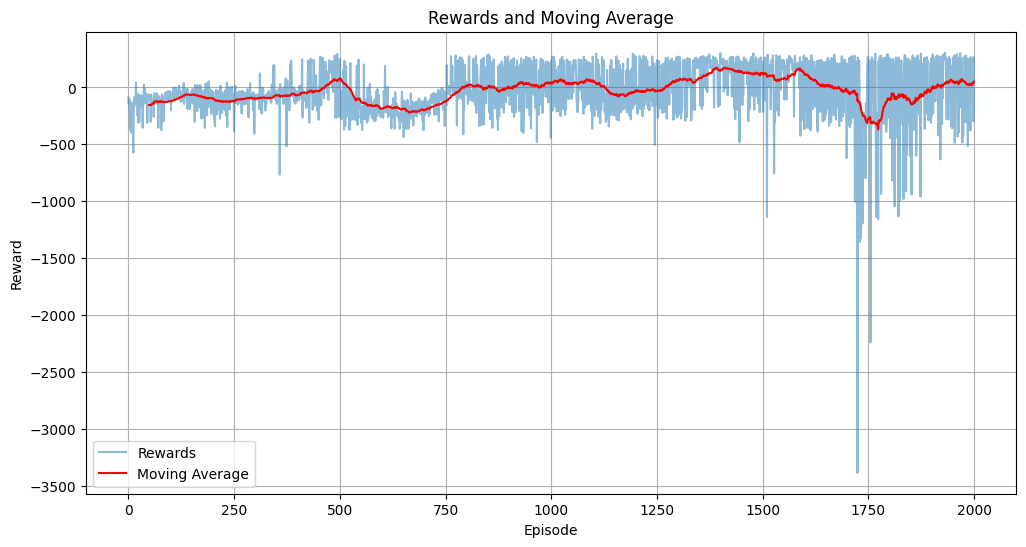

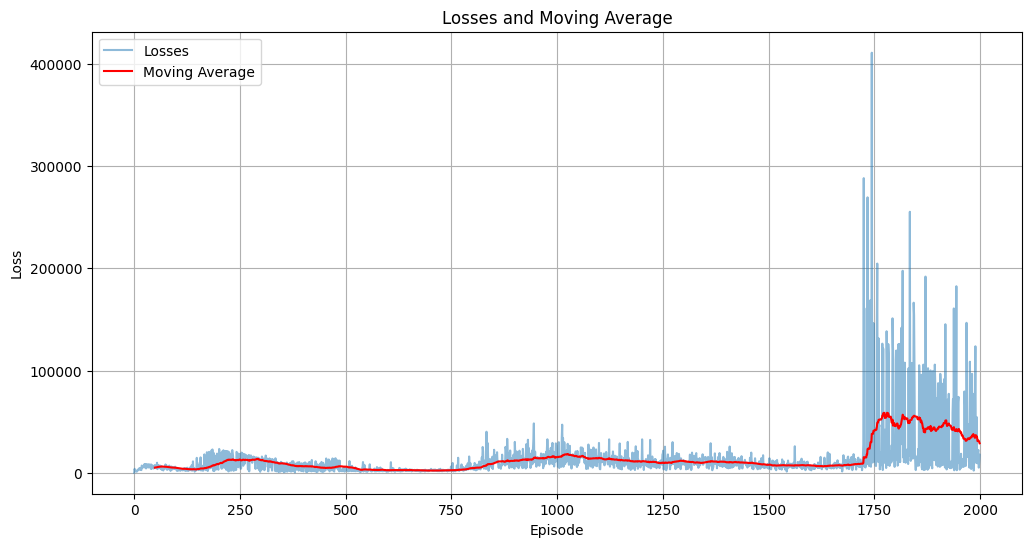

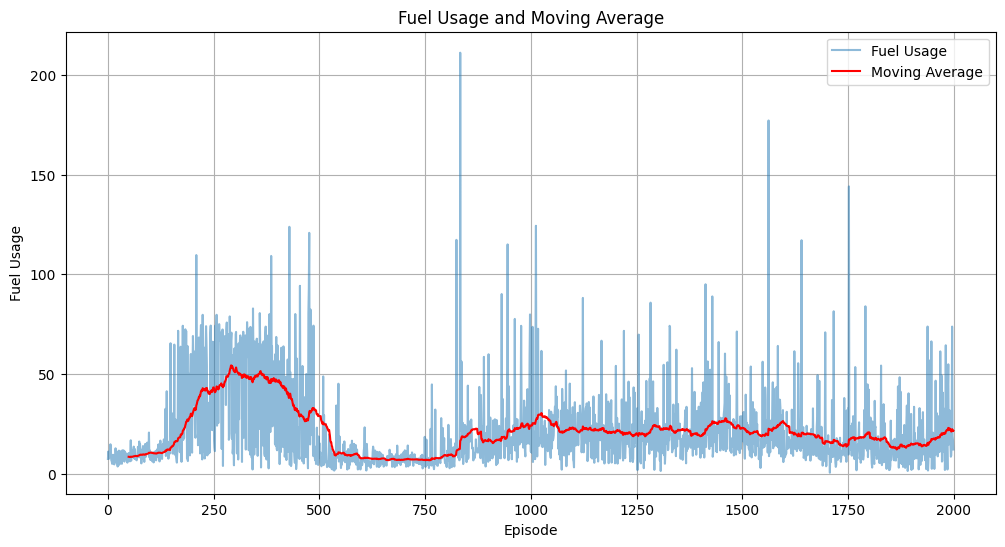

In [302]:
trainer.plot_results()

In [303]:
trainer.save_model("dqn_lunarlander-2k-adam-1e-3.pth")

In [304]:
trainer.load_model("dqn_lunarlander-2k-adam-1e-3.pth")

/tmp/ipykernel_1814/1574679944.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target_net.load_state_dict(torch.load(path))


In [305]:
trainer.test_model(episodes=500)

Success: 187/500 | Success Rate: 37.40%


Success: 187/500 | Success Rate: 37.40%

In [306]:
trainer.display_sample_video(sample_video=5)